# DiseaseIDNet CNN, used to classify potato disease

## Imports

Import the required libraries.

In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

## Filepaths
Filepaths to the dataset.

In [19]:
######################## FILEPATHS ########################
fp_to_test_dataset_labels = "../..dataset/PlantVillage/dataset_labels.csv"
fp_to_training_dataset_labels = "../..dataset/PlantVillage/dataset_training_labels.csv"
fp_to_validation_dataset_labels = "../..dataset/PlantVillage/dataset_validation_labels.csv"
fp_to_dataset_imgs = "../..dataset/PlantVillage/collectedSeg"

fp_to_net_dir = "diseaseID_net3_100epoch_WD01"

## Dataset
Parameters used to manage the dataset.

In [20]:
######################## DATASET PARAMETERS ########################
scale_ims_to = 64                                # Images are downsampled to this many pixels
list_of_classes = ['early_blight','late_blight'] # Class names

### Network
Parameters used to define the network

In [21]:
conv_kernel_dim = 5

### Training
Parameters used to manage training.

In [22]:
######################## TRAINING PARAMETERS ########################
batch_size = 100
num_epochs = 100
learning_rate = 0.001
sgd_momentum = 0.7
weight_decay = 0.01
output_freq = 50        # update logs every n batches

## Helper Functions
Define some helper functions to handle data display

In [23]:
# Some helper functions 

# display an image from dataset
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# display a sample and print the class label
def show_sample(img, label):
    imshow(img)
    print(label)
    
# function to evaluate the accuracy of a network on a dataset
# inputs:
    # dataloader - dataset loader pointing to the dataset to evaluate
    # net - network to evaluate
    # list_of_classes - class labels
    # n - number of samples in dataset
    # criterion - loss function, if None do not evalute loss
# returns
    # acc - dict containing accuracy info
def eval_acc(dataloader, net, list_of_classes, n, device = None, criterion = None):
    
    running_loss = 0
    results = []
    
    with torch.no_grad():  # we don't need to be able to backprop
        # for each batch from the dataloader
        for data in dataloader:
            
            # get the inputs and labels
            inputs, labels = data['image'], data['label']

            # use GPU if avail
            if device != None:
                inputs, labels = inputs.to(device), labels.to(device)
            
            # forward prop on the samples
            outputs = net(inputs)
            
            # extract the predictions and labels (as integer values)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            
            # if a loss function is provided, calculate the loss
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()                
            
            # mark samples correct
            c = (predicted == labels)
            
            # assemble results dataframe
            result = np.concatenate([labels.numpy().transpose()[:,None],
                                     predicted.numpy().transpose()[:,None],
                                     c.numpy().transpose()[:,None]],axis=1)
            results.append(pd.DataFrame(result, columns=['Labels','Predicted','Correct']))
    
    results = pd.concat(results)
    
    # list to store per class accuracy results
    acc_per_class = []
        
    # for each class:
    for i in range(len(list_of_classes)):

        # how many samples are there
        class_total = results[results['Labels'] == i].shape[0]

        # how many predictions are correct
        class_correct = results[(results['Labels'] == i) & (results['Correct'] == True)].shape[0]

        # calculate the % accuracy
        acc_per_class.append(100 * class_correct/class_total)
    
    # how many total correct predictions are there
    correct = results[results['Correct'] == True].shape[0]
    # how many total samples are there
    total = results.shape[0]
    
    # assemble everything to return
    acc = { 'total': 100 * correct / total,
            'per_class': acc_per_class,
            'loss': running_loss / total,
            'results': results}
    
    return acc

def plot_learning_curve(log_of_loss, log_of_acc_val = None, title=None):

    plt.figure()
    plt.plot(log_of_loss)
    
    if log_of_acc_val != None:
        plt.plot(log_of_acc_val)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if title != None:
        plt.title(title)
    else:
        plt.title("Learning Curve")

    plt.grid()
    
    plt.savefig(fp_to_net_dir + title + '_learning_plot.png')
    plt.show()

## Dataset Class

Now, define a new subclass of the PyTorch dataset class.

This code is based heavily on the tutorial "Writing Custom Datasets, DataLoaders and Transforms," available here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

It has been customized to the work with the plant disease dataset.

In [24]:
######################## DATASET CLASS ########################
class PlantIdentificationDataSet(Dataset): 
    
    # TODO: Implement ToTensor() transform as a default transform
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = self.load_labels(csv_file)             # load data labels
        self.root_dir = root_dir                             # image file locations
        self.transform = transform                           # transforms to apply to images
        
    def load_labels(self,csv_file):
        labels = pd.read_csv(csv_file)
        labels.drop(labels[labels['plant'] != 'potato'].index , inplace=True)
        labels.drop(labels[labels['disease'] == "healthy"].index , inplace=True)
        labels = labels.join(pd.get_dummies(labels['disease'] == 'early_blight'))       # boolean
        labels = labels.drop(columns=['plant', 'disease'],axis=1)     # only need plant class OHE vector
        print("Loaded " + str(len(labels)) + " datapoints")
        return labels
    
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,               # get the path to this image
                                self.labels.iloc[idx]['filename'])
        
        # Try to load the image, and print an error if it can't be found
        try:
            image = io.imread(img_name)
        except:
            print("Something is wrong with image {}".format(self.labels.iloc[idx]['filename']))

        label = (self.labels.iloc[idx][2:5])
        
        sample = {'image': image, 'label': label}
        
        # if a transform has been specificed, apply it before returning the sample
        # Note: the transform "ToTensor" MUST be applied
        if self.transform:
            sample = self.transform(sample)
        
        return sample

    

######################## TRANSFORM CLASSES ########################
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        image = transform.resize(image, (self.output_size, self.output_size))
        
        return {'image': image, 'label': label}

class ToTensor(object):

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.transpose((2,0,1))
        return{'image': torch.from_numpy(image).float(),
               'label': torch.from_numpy(label.to_numpy().astype('bool'))}


### Load training data
Load the training set, and display some samples.

Loaded 1601 datapoints
{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'label': tensor([False,  True])}
0 torch.Size([100, 3, 64, 64]) torch.Size([100, 2])


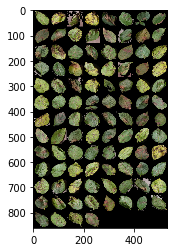

In [25]:
training_dataset = PlantIdentificationDataSet(fp_to_training_dataset_labels,
                                              fp_to_dataset_imgs,
                                              transform=transforms.Compose([Rescale(scale_ims_to),
                                                                            ToTensor()]))
print(training_dataset[100])

# Iterate through the dataset using DataLoader
trainLoader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
for i_batch, sample_batched in enumerate(trainLoader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'].size())
    #show_images_batch(sample_batched)
    imshow(torchvision.utils.make_grid(sample_batched['image']))
    if i_batch == 0: break

In [26]:
val_dataset = PlantIdentificationDataSet(fp_to_validation_dataset_labels,
                                         fp_to_dataset_imgs,
                                         transform=transforms.Compose([Rescale(scale_ims_to),
                                                                       ToTensor()]))

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loaded 359 datapoints


## Define the network.

The current network is 2 convolutional layers, the first with 6 channels and the second with 16.  Both layers consist of 5x5 kernels, and are connected by a 2x2 maxpooling layer.

The convolutional network feeds into 3 fully connected layers.

In [27]:
# Define a CNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool1_output_size = (int)((scale_ims_to - conv_kernel_dim + 1) / 2)
        self.pool2_output_size = (int)((self.pool1_output_size - conv_kernel_dim + 1) / 2)
        
        self.conv1 = nn.Conv2d(3, 6, conv_kernel_dim)
        self.pool = nn.MaxPool2d(2, 2)        
        self.conv2 = nn.Conv2d(6, 16, conv_kernel_dim)
        self.fc1 = nn.Linear(16 * self.pool2_output_size ** 2, 120) # 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * self.pool2_output_size ** 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
# Function to train a net with given parameters
def train_a_net(train_loader, val_loader, val_dataset, weight_decay, lr, momentum, print_epochs=True):
    print ('****** BEGIN NETWORK TRAINING ******')
    print('Training for {} epochs...'.format(num_epochs))
    print('Using weight decay parameter of ' + str(weight_decay) + '...')

    # network, cross entropy, and optimizer
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), weight_decay=weight_decay, lr=learning_rate, momentum = sgd_momentum)

    # lists to log loss on training and validation datasets
    log_of_training_loss, log_of_validation_loss = [], []
    
    # train epochs
    print ('****** BEGIN NETWORK TRAINING ******')
    for epoch in range(num_epochs):
        training_loss = 0.0
        # train for 1 epoch, 1 mini batch at a time
        for i, data, in enumerate(trainLoader):
            # get the inputs; data list a list of [inputs, labels]
            inputs, labels = data['image'], data['label'] 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward prop
            outputs = net(inputs)
            # calculate the loss
            labels = torch.max(labels,1)[1] # cross entropy loss expects class indices, so convert from ohe
            loss = criterion(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # update the weights
            optimizer.step()
            # print statistics
            training_loss += loss.item()

        # after one epoch, normalize the loss and log it
        training_loss = training_loss/len(training_dataset)
        log_of_training_loss.append(training_loss)

        # check the accuracy on the validation dataset and log it
        acc_on_val = eval_acc(val_loader, net, list_of_classes, n = len(val_dataset), criterion = criterion)
        validation_loss = acc_on_val['loss']
        log_of_validation_loss.append(validation_loss)
        if (print_epochs): print("[Epoch " + str(epoch) + "/"+ str(num_epochs) + "] Training Loss: {0:7.5f}, Validation Loss: {1:7.5f}".format(training_loss, validation_loss))
    print ('****** FINISHED NETWORK TRAINING ******')

    # Plot the learning curve
    plot_learning_curve(log_of_training_loss, log_of_validation_loss, title="plantID_net_50epoch")

    ############## TEST AGAINST THE VALIDATION DATASET ##############
    print ('****** LOADING VALIDATION DATASET ******')
    val_dataset = PlantIdentificationDataSet(fp_to_validation_dataset_labels,
                                             fp_to_dataset_imgs,
                                             transform=transforms.Compose([Rescale(scale_ims_to), ToTensor()])
                                            )

    # create a new validation dataset dataloader
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # evaluate the model on the validation dataset
    print ('****** EVALUATING VALIDATION DATASET ******')        
    acc = eval_acc(val_loader, net, list_of_classes, len(val_dataset))
    print('Accuracy of the network on the validation images: %d %%' % (acc['total']))
    for i in range(len(list_of_classes)): print('Accuracy of {} : {} %'.format(list_of_classes[i], acc['per_class'][i]))
    print ('****** FINISHED VALIDATION ******\n\n')

    # return log losses
    return [log_of_training_loss, log_of_validation_loss], net

### Start training

****** BEGIN NETWORK TRAINING ******
Training for 100 epochs...
Using weight decay parameter of 0.01...
****** BEGIN NETWORK TRAINING ******
[Epoch 0/100] Training Loss: 0.00740, Validation Loss: 0.00776
[Epoch 1/100] Training Loss: 0.00740, Validation Loss: 0.00775
[Epoch 2/100] Training Loss: 0.00739, Validation Loss: 0.00775
[Epoch 3/100] Training Loss: 0.00735, Validation Loss: 0.00774
[Epoch 4/100] Training Loss: 0.00735, Validation Loss: 0.00774
[Epoch 5/100] Training Loss: 0.00734, Validation Loss: 0.00774
[Epoch 6/100] Training Loss: 0.00734, Validation Loss: 0.00774
[Epoch 7/100] Training Loss: 0.00739, Validation Loss: 0.00774
[Epoch 8/100] Training Loss: 0.00739, Validation Loss: 0.00774
[Epoch 9/100] Training Loss: 0.00738, Validation Loss: 0.00773
[Epoch 10/100] Training Loss: 0.00738, Validation Loss: 0.00773
[Epoch 11/100] Training Loss: 0.00734, Validation Loss: 0.00773
[Epoch 12/100] Training Loss: 0.00733, Validation Loss: 0.00772
[Epoch 13/100] Training Loss: 0.00737

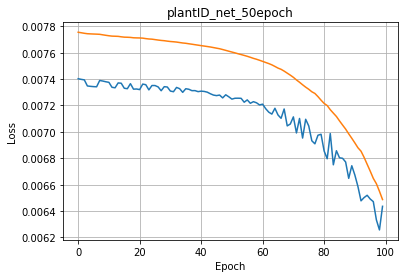

****** LOADING VALIDATION DATASET ******
Loaded 359 datapoints
****** EVALUATING VALIDATION DATASET ******
Accuracy of the network on the validation images: 86 %
Accuracy of early_blight : 72.12121212121212 %
Accuracy of late_blight : 97.9381443298969 %
****** FINISHED VALIDATION ******




In [30]:
# Train with some parameters

losses, net = train_a_net(trainLoader, val_loader, val_dataset, weight_decay, learning_rate, sgd_momentum)

Evaluate the network against the validation dataset, and print out the per-class performance.

****** LOADING TEST DATASET ******
Loaded 2000 datapoints
****** EVALUATING TEST DATASET ******
Accuracy of the network on the test images: 81 %
Accuracy of early_blight : 67.6 %
Accuracy of late_blight : 96.0 %

***** ACCURACY METRICS *****
early_blight: Precision: 0.944 Recall: 0.676 FScore: 0.788
late_blight: Precision: 0.748 Recall: 0.960 FScore: 0.841

***** RAW CONFUSION MATRIX *****
[[676 324]
 [ 40 960]]

***** NORMALIZED CONFUSION MATRIX *****
[[0.676 0.324]
 [0.04  0.96 ]]


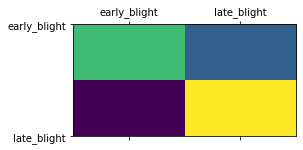

In [31]:
print ('****** LOADING TEST DATASET ******')
test_dataset = PlantIdentificationDataSet(fp_to_test_dataset_labels,
                                          fp_to_dataset_imgs,
                                          transform=transforms.Compose([Rescale(scale_ims_to),
                                                                        ToTensor()]))

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
acc = eval_acc(test_loader, net, list_of_classes, len(test_dataset))

print ('****** EVALUATING TEST DATASET ******')            
print('Accuracy of the network on the test images: %d %%' % ( acc['total']))
for i in range(len(list_of_classes)): print('Accuracy of {} : {} %'.format(list_of_classes[i], acc['per_class'][i]))

print("\n***** ACCURACY METRICS *****")
y_true = acc['results']['Labels']
y_pred = acc['results']['Predicted']
prf_per_class = precision_recall_fscore_support(y_true, y_pred)
for i in range(len(list_of_classes)):
    print("{0}: Precision: {1:0.3f} Recall: {2:0.3f} FScore: {3:0.3f}".format(list_of_classes[i], prf_per_class[0][i], prf_per_class[1][i], prf_per_class[2][i]))

print("\n***** RAW CONFUSION MATRIX *****")
raw_confusion_matrix = confusion_matrix(y_true, y_pred)
print(raw_confusion_matrix)

norm_confusion_matrix = raw_confusion_matrix.astype('float64')
for i in range(len(raw_confusion_matrix)):
    sum = np.sum(raw_confusion_matrix[i,:])
    norm_confusion_matrix[i,:] = raw_confusion_matrix[i,:] / sum
print("\n***** NORMALIZED CONFUSION MATRIX *****")
print(norm_confusion_matrix)

# display confusion matrix
plt.matshow(norm_confusion_matrix)
plt.xticks([0,1],labels=list_of_classes)
plt.yticks([0,1],labels=list_of_classes)
plt.show()

## Save and load the network
### Save

In [163]:
torch.save(net.state_dict(), fp_to_net_dir + 'HealthID_net_params.pth')

### Load

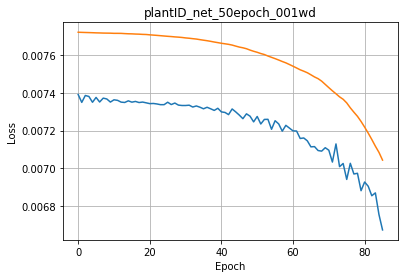

In [164]:
# net = Net()
# net.load_state_dict(torch.load(fp_to_net))
plot_learning_curve(log_of_training_loss, log_of_validation_loss, title="plantID_net_50epoch_001wd")

In [165]:
### Iterate over multiple weights

In [1]:
# assumes train_a_net function instantiated

weight_decay_rates = [0, 0.0001, 0.001, 0.01, 0.1]
log_of_losses = []
for weight_decay_rate in weight_decay_rates:
    losses, net = train_a_net(trainLoader, val_loader, val_dataset, weight_decay_rate, learning_rate, sgd_momentum, print_epochs=False)
    log_of_losses.append(losses)